# Fine-tune GPT-2 on NCERT Class 7 Text Data
This notebook trains a GPT-2 model on Class 7 NCERT content to serve as a personalized teacher/coach.

In [4]:
# Uncomment the lines below to install required libraries if not already installed
!pip install transformers datasets torch accelerate matplotlib


In [5]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling
import torch
from datetime import datetime


/Users/datta/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Set paths for data
base_dir = "./pdf_data_to_raw_text"  # Replace with the directory containing your NCERT text files
save_model_dir = "./class7_gpt2_model"

# Load and prepare dataset
def load_text_files(base_dir):
    """Load all text files from a directory and subdirectories."""
    text_data = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    text_data.append(f.read())
    return text_data

print(f"{datetime.now()} - Loading text data...")
text_data = load_text_files(base_dir)
print(f"{datetime.now()} - Loaded {len(text_data)} text files.")

# Create Hugging Face Dataset
dataset = Dataset.from_dict({"text": text_data})
print(f"{datetime.now()} - Dataset created with {len(dataset)} examples.")


2024-11-22 18:19:09.633266 - Loading text data...
2024-11-22 18:19:09.656984 - Loaded 71 text files.
2024-11-22 18:19:09.668658 - Dataset created with 71 examples.


In [7]:
# Load tokenizer
print(f"{datetime.now()} - Loading tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add padding token for training

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=1024)

print(f"{datetime.now()} - Tokenizing dataset...")
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
print(f"{datetime.now()} - Tokenization complete.")


2024-11-22 18:19:12.897439 - Loading tokenizer...
2024-11-22 18:19:13.842618 - Tokenizing dataset...


Map: 100%|██████████| 71/71 [00:01<00:00, 60.49 examples/s]

2024-11-22 18:19:15.708638 - Tokenization complete.


In [8]:
#Splitting into Chunks: This step ensures all examples in your dataset conform to the model's context window limit.
MAX_LENGTH = 1024  # Define the model's maximum sequence length

def split_into_chunks(batch):
    input_ids = batch['input_ids']
    chunks = [input_ids[i:i+MAX_LENGTH] for i in range(0, len(input_ids), MAX_LENGTH)]
    return {'input_ids': chunks}

print("Splitting long sequences into chunks...")
tokenized_dataset = tokenized_dataset.map(split_into_chunks, batched=False)
print("Splitting into chunks done")

# Formatting Data for Training:
# Before training, you'll need to ensure the dataset is flattened, as splitting can create nested lists. Use Dataset.flatten() if necessary:
# tokenized_dataset = tokenized_dataset.flatten()
# print("data flattened successfully")

Splitting long sequences into chunks...


Map: 100%|██████████| 71/71 [00:00<00:00, 1507.74 examples/s]

Splitting into chunks done


Token indices sequence length is longer than the specified maximum sequence length for this model (5565 > 1024). Running this sequence through the model will result in indexing errors


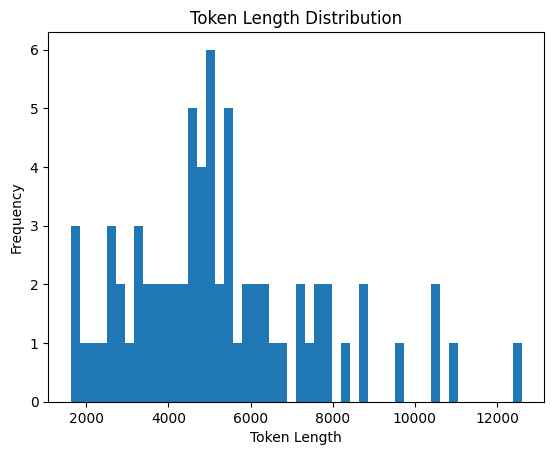

In [9]:
# Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # GPT-2 is not a masked language model
)

# Visualize tokenized data distribution
token_lengths = [len(tokenizer(text)["input_ids"]) for text in text_data]
plt.hist(token_lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()


In [10]:
# Load GPT-2 Model
print(f"{datetime.now()} - Loading GPT-2 model...")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))  # Adjust token embeddings
print(f"{datetime.now()} - Model loaded.")


2024-11-22 18:19:26.565407 - Loading GPT-2 model...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


2024-11-22 18:19:29.633692 - Model loaded.


In [14]:
# Define Training Arguments
# training_args = TrainingArguments(
#     output_dir=save_model_dir,
#     eval_strategy="epoch",
#     learning_rate=5e-5,
#     weight_decay=0.01,
#     num_train_epochs=3,
#     per_device_train_batch_size=2,  # Adjust based on GPU memory
#     save_steps=10_000,
#     save_total_limit=2,
#     fp16=True,  # Mixed precision training for faster computation on M1
#     report_to="none",
# )
training_args = TrainingArguments(
    output_dir=save_model_dir,
    eval_strategy="epoch",  # Keep evaluation if required
    save_strategy="epoch",        # Align save strategy with evaluation
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=False,                   # Disable fp16 for MPS
    use_cpu=True                  # Ensures usage of MPS backend instead of CUDA
)




print(f"{datetime.now()} - Training arguments configured.")


2024-11-22 18:20:34.837775 - Training arguments configured.


In [15]:
# Fix: Add Labels to the Dataset
# To fix this, you need to add a labels field to your dataset. For language modeling tasks (like fine-tuning GPT-2), the labels are usually the same as the input_ids.

# Here’s how to modify the dataset:

# Update the Dataset to Include Labels

def add_labels(batch):
    # Use `input_ids` as labels for causal language modeling
    batch["labels"] = batch["input_ids"].copy()
    return batch

tokenized_dataset = tokenized_dataset.map(add_labels, batched=True)
# Make sure you apply this update before splitting the dataset or passing it to the Trainer.

Map: 100%|██████████| 71/71 [00:00<00:00, 1607.77 examples/s]


In [16]:
# Split the dataset using Hugging Face's train_test_split
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# Extract train and evaluation datasets
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"Train dataset: {len(train_dataset)} examples")
print(f"Eval dataset: {len(eval_dataset)} examples")


Train dataset: 56 examples
Eval dataset: 15 examples


In [17]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://download.pytorch.org/whl/nightly/cpu


In [18]:
# Ensure the Correct Device
# Verify that your training script is correctly set up to use "mps" as the training device. To explicitly set the device:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# model.to(device)
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device:", device)
else:
    print("MPS device not available, using CPU")

Using MPS device: mps


In [20]:
# Create Trainer
# print(f"{datetime.now()} - Setting up Trainer...")
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_dataset,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
# )
# Create Trainer
print(f"{datetime.now()} - Setting up Trainer...")
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)


print(f"{datetime.now()} - Trainer setup complete.")


# Train Model
print(f"{datetime.now()} - Starting training...")
trainer.train()
print(f"{datetime.now()} - Training complete.")

# Save the model
print(f"{datetime.now()} - Saving model to {save_model_dir}...")
model.save_pretrained(save_model_dir)
tokenizer.save_pretrained(save_model_dir)


2024-11-22 18:39:09.515107 - Setting up Trainer...
2024-11-22 18:39:09.536308 - Trainer setup complete.
2024-11-22 18:39:09.536373 - Starting training...


                                               
 93%|█████████▎| 39/42 [22:34<01:19, 26.62s/it]

{'loss': 2.8154, 'grad_norm': 6.206544876098633, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.71}






                                               

                                       
 93%|█████████▎| 39/42 [24:29<01:19, 26.62s/it]



{'eval_loss': 2.950634002685547, 'eval_runtime': 8.8047, 'eval_samples_per_second': 1.704, 'eval_steps_per_second': 0.454, 'epoch': 1.0}


                                               
 93%|█████████▎| 39/42 [27:09<01:19, 26.62s/it]

{'loss': 2.7329, 'grad_norm': 3.80417537689209, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}






                                               

                                       
 93%|█████████▎| 39/42 [30:46<01:19, 26.62s/it]



{'eval_loss': 2.911417245864868, 'eval_runtime': 9.1438, 'eval_samples_per_second': 1.64, 'eval_steps_per_second': 0.437, 'epoch': 2.0}


                                               
 93%|█████████▎| 39/42 [31:41<01:19, 26.62s/it]

{'loss': 2.7229, 'grad_norm': 3.7061266899108887, 'learning_rate': 1.4285714285714285e-05, 'epoch': 2.14}


                                               
 93%|█████████▎| 39/42 [36:02<01:19, 26.62s/it]

{'loss': 2.6599, 'grad_norm': 3.821566581726074, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}






                                               

                                       
 93%|█████████▎| 39/42 [37:06<01:19, 26.62s/it]



{'eval_loss': 2.89694881439209, 'eval_runtime': 11.019, 'eval_samples_per_second': 1.361, 'eval_steps_per_second': 0.363, 'epoch': 3.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
                                               
100%|██████████| 42/42 [19:02<00:00, 27.20s/it]


{'train_runtime': 1142.4692, 'train_samples_per_second': 0.147, 'train_steps_per_second': 0.037, 'train_loss': 2.7262948808215914, 'epoch': 3.0}
2024-11-22 18:58:12.256061 - Training complete.
2024-11-22 18:58:12.256263 - Saving model to ./class7_gpt2_model...


('./class7_gpt2_model/tokenizer_config.json',
 './class7_gpt2_model/special_tokens_map.json',
 './class7_gpt2_model/vocab.json',
 './class7_gpt2_model/merges.txt',
 './class7_gpt2_model/added_tokens.json')

In [22]:
# Test the Trained Model
def generate_response(prompt, max_length=50):
    """Generate response using the trained model."""
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(torch.device("mps"))
    outputs = model.generate(
        inputs,
        max_length=max_length,
        num_return_sequences=1,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.pad_token_id,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example Test
prompt = "Explain the properties of integers."
response = generate_response(prompt)
print("Response:", response)


RuntimeError: Placeholder storage has not been allocated on MPS device!